## This notebook shows how to use Grizli to

model contamination and fit continuum + emission models for G102/G141 observations for a single object in the CLEAR GS1. This create 1D and 2D spectra and line maps.

These series of notebooks draw heavily from Gabe Brammer's existing grizli notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with examples specific for the CLEAR survey.

In [56]:
%matplotlib inline
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import drizzlepac
import grizli
import glob
from grizli import utils
import importlib
from grizli.prep import process_direct_grism_visit
from hsaquery import query, overlaps
from grizli.pipeline import auto_script
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import os
from grizli.pipeline import photoz
from astropy.table import Table
import eazy
from IPython.display import Image


## The paths defined below need to be changed to your own directories.
### PATH_TO_CATS should include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
### these are all available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/
### HOME_PATH is where the raw data, reduced data, and grizli outputs will be stored


In [57]:
field           = 'GS1'
ref_filter      = 'F105W'
HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_SCRIPTS = '/Users/rsimons/Desktop/git/clear_local/example_notebooks'
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'
PATH_TO_RAW     = glob.glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob.glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500 # really only necessary for GDN
            self.radec_catalog = PATH_TO_CATS + '/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            
            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodsn_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'


            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodss_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')




def readEazyBinary(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY='./OUTPUT', CACHE_FILE='Same'):

    """
    Author: Gabe Brammer
    This function has been clipped from eazyPy.py in the threedhst git respository
    https://github.com/gbrammer/threedhst/tree/master/threedhst

    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.
    
    If the BINARY_OUTPUTS files are not in './OUTPUT', provide either a relative or absolute path
    in the OUTPUT_DIRECTORY keyword.
    
    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise. 
    """
    
    #root='COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU'
    
    root = OUTPUT_DIRECTORY+'/'+MAIN_OUTPUT_FILE
    
    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root+'.tempfilt'
    
    if os.path.exists(CACHE_FILE) is False:
        print(('File, %s, not found.' %(CACHE_FILE)))
        return -1,-1,-1,-1
    
    f = open(CACHE_FILE,'rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    tempfilt = np.fromfile(file=f,dtype=np.double,count=NFILT*NTEMP*NZ).reshape((NZ,NTEMP,NFILT)).transpose()
    lc = np.fromfile(file=f,dtype=np.double,count=NFILT)
    zgrid = np.fromfile(file=f,dtype=np.double,count=NZ)
    fnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    efnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    
    f.close()
    
    tempfilt  = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
                 'tempfilt':tempfilt,'lc':lc,'zgrid':zgrid,'fnu':fnu,'efnu':efnu}
    
    ###### .coeff
    f = open(root+'.coeff','rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    coeffs = np.fromfile(file=f,dtype=np.double,count=NTEMP*NOBJ).reshape((NOBJ,NTEMP)).transpose()
    izbest = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
    tnorm = np.fromfile(file=f,dtype=np.double,count=NTEMP)
    
    f.close()
    
    coeffs = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
              'coeffs':coeffs,'izbest':izbest,'tnorm':tnorm}
              
    ###### .temp_sed
    f = open(root+'.temp_sed','rb')
    s = np.fromfile(file=f,dtype=np.int32, count=3)
    NTEMP=s[0]
    NTEMPL=s[1]
    NZ=s[2]
    templam = np.fromfile(file=f,dtype=np.double,count=NTEMPL)
    temp_seds = np.fromfile(file=f,dtype=np.double,count=NTEMPL*NTEMP).reshape((NTEMP,NTEMPL)).transpose()
    da = np.fromfile(file=f,dtype=np.double,count=NZ)
    db = np.fromfile(file=f,dtype=np.double,count=NZ)
    
    f.close()
    
    temp_sed = {'NTEMP':NTEMP,'NTEMPL':NTEMPL,'NZ':NZ,\
              'templam':templam,'temp_seds':temp_seds,'da':da,'db':db}
              
    ###### .pz
    if os.path.exists(root+'.pz'):
        f = open(root+'.pz','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=2)
        NZ=s[0]
        NOBJ=s[1]
        chi2fit = np.fromfile(file=f,dtype=np.double,count=NZ*NOBJ).reshape((NOBJ,NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        
        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f,dtype=np.double,count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ*NK).reshape((NK,NZ)).transpose()
            kidx = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
            pz = {'NZ':NZ,'NOBJ':NOBJ,'NK':NK, 'chi2fit':chi2fit, 'kbins':kbins, 'priorzk':priorzk,'kidx':kidx}
        else:
            pz = None
        
        f.close()
        
    else:
        pz = None
    
    if False:
        f = open(root+'.zbin','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        NOBJ=s[0]
        z_a = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_p = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m1 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m2 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_peak = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        f.close()
        
    ###### Done.    
    return tempfilt, coeffs, temp_sed, pz



In [3]:
os.chdir(PATH_TO_PREP)
files = glob.glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


In [10]:
product_names = np.array([visit['product'] for visit in visits])
filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])


In [24]:
all_grism_files = []
all_direct_files = []

ref_filter_1 = 'F105W' 
ref_filter_2 = 'F140W'

ref_grism_1 = 'G102'
ref_grism_2 = 'G141'

for v, visit in enumerate(visits):
    product = product_names[v]
    basename = basenames[v]
    filt1 = filter_names[v]
    if (ref_filter_1.lower() in filt1) or (ref_filter_2.lower() in filt1):
        all_direct_files.extend(visit['files'])
        grism_index_1 = np.where((basenames == basename) & (filter_names == ref_grism_1.lower()))[0]
        grism_index_2 = np.where((basenames == basename) & (filter_names == ref_grism_2.lower()))[0]
        if len(grism_index_1) > 0:
            all_grism_files.extend(visits[grism_index_1[0]]['files'])
        if len(grism_index_2) > 0:
            all_grism_files.extend(visits[grism_index_2[0]]['files'])
        
print ('Number of direct files:', len(all_direct_files))
print ('Number of grism files:', len(all_grism_files))


Number of direct files: 16
Number of grism files: 28


In [25]:
p = Pointing(field = field, ref_filter = ref_filter_1)
print('Initializing (or loading pre-existing) contamination models...')

grp = GroupFLT(grism_files=all_grism_files, 
               direct_files=[], 
               ref_file = p.ref_image,
               seg_file = p.seg_map,
               catalog  = p.catalog,
               pad=p.pad,
               cpu_count=8)

File, /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.tempfilt, not found.
Loading contamination models...
Load ibhj01iqq.01.GrismFLT.fits!
Load ibhj01ixq.01.GrismFLT.fits!
Load ibhj01j4q.01.GrismFLT.fits!
Load ibhj01jbq.01.GrismFLT.fits!
Load icxt09f0q.01.GrismFLT.fits!
Load icxt09f2q.01.GrismFLT.fits!
Load icxt09f5q.01.GrismFLT.fits!
Load icxt09f7q.01.GrismFLT.fits!
Load icxt10dbq.01.GrismFLT.fits!
Load icxt10deq.01.GrismFLT.fits!
Load icxt10diq.01.GrismFLT.fits!
Load icxt10dkq.01.GrismFLT.fits!
Load icxt07dxq.01.GrismFLT.fits!
Load icxt07dzq.01.GrismFLT.fits!
Load icxt07e2q.01.GrismFLT.fits!
Load icxt07e4q.01.GrismFLT.fits!
Load icxt08e7q.01.GrismFLT.fits!
Load icxt08e9q.01.GrismFLT.fits!
Load icxt08ecq.01.GrismFLT.fits!
Load icxt08eeq.01.GrismFLT.fits!
Load icxt11qiq.01.GrismFLT.fits!
Load icxt11qkq.01.GrismFLT.fits!
Load icxt11qnq.01.GrismFLT.fits!
Load icxt11qpq.01.GrismFLT.fits!
Load icxt12qvq.01.GrismFLT.fits!
Load icxt12qxq.01.GrismFLT.fits!
Load icxt12r0q.01.GrismFLT.

## Contamination models

In [29]:
print('Computing first-pass contamination models...')
grp.compute_full_model(mag_limit = 25)

Computing first-pass contamination models...
ibhj01iqq_flt.fits: _compute_model Done
ibhj01ixq_flt.fits: _compute_model Done
ibhj01j4q_flt.fits: _compute_model Done
ibhj01jbq_flt.fits: _compute_model Done
icxt09f0q_flt.fits: _compute_model Done
icxt09f2q_flt.fits: _compute_model Done
icxt09f5q_flt.fits: _compute_model Done
icxt09f7q_flt.fits: _compute_model Done
icxt10dbq_flt.fits: _compute_model Done
icxt10deq_flt.fits: _compute_model Done
icxt10diq_flt.fits: _compute_model Done
icxt10dkq_flt.fits: _compute_model Done
icxt07dxq_flt.fits: _compute_model Done
icxt07dzq_flt.fits: _compute_model Done
icxt07e2q_flt.fits: _compute_model Done
icxt07e4q_flt.fits: _compute_model Done
icxt08e7q_flt.fits: _compute_model Done
icxt08e9q_flt.fits: _compute_model Done
icxt08ecq_flt.fits: _compute_model Done
icxt08eeq_flt.fits: _compute_model Done
icxt11qiq_flt.fits: _compute_model Done
icxt11qkq_flt.fits: _compute_model Done
icxt11qnq_flt.fits: _compute_model Done
icxt11qpq_flt.fits: _compute_model 

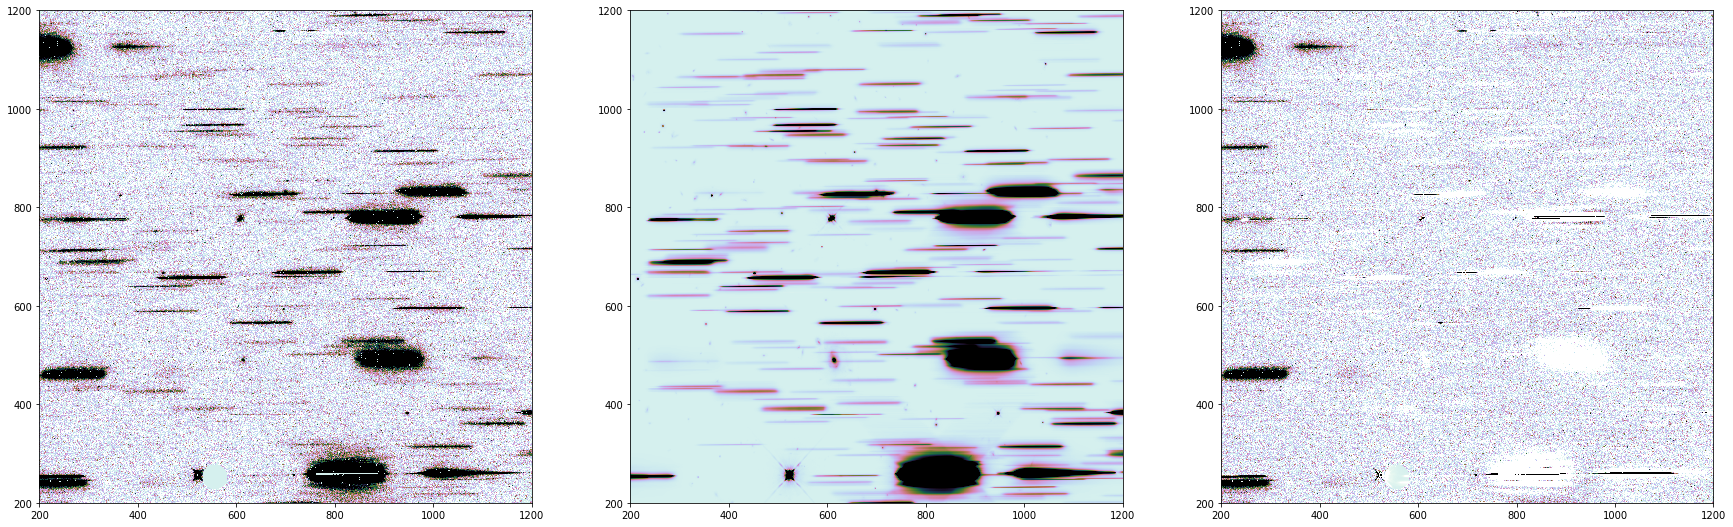

In [41]:
fig.clf()
fig, axes = plt.subplots(1,3, figsize=[30,10])
axes[0].imshow(grp.FLTs[0].grism['SCI'], vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[1].imshow(grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[2].imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')

for ax in axes:
    ax.set_xlim(200,1200) 
    ax.set_ylim(200,1200)
    



In [42]:
print('Re-computing continuum models, but with higher-order polynomials..')
grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

Refining the continuum models with higher-order polynomials..


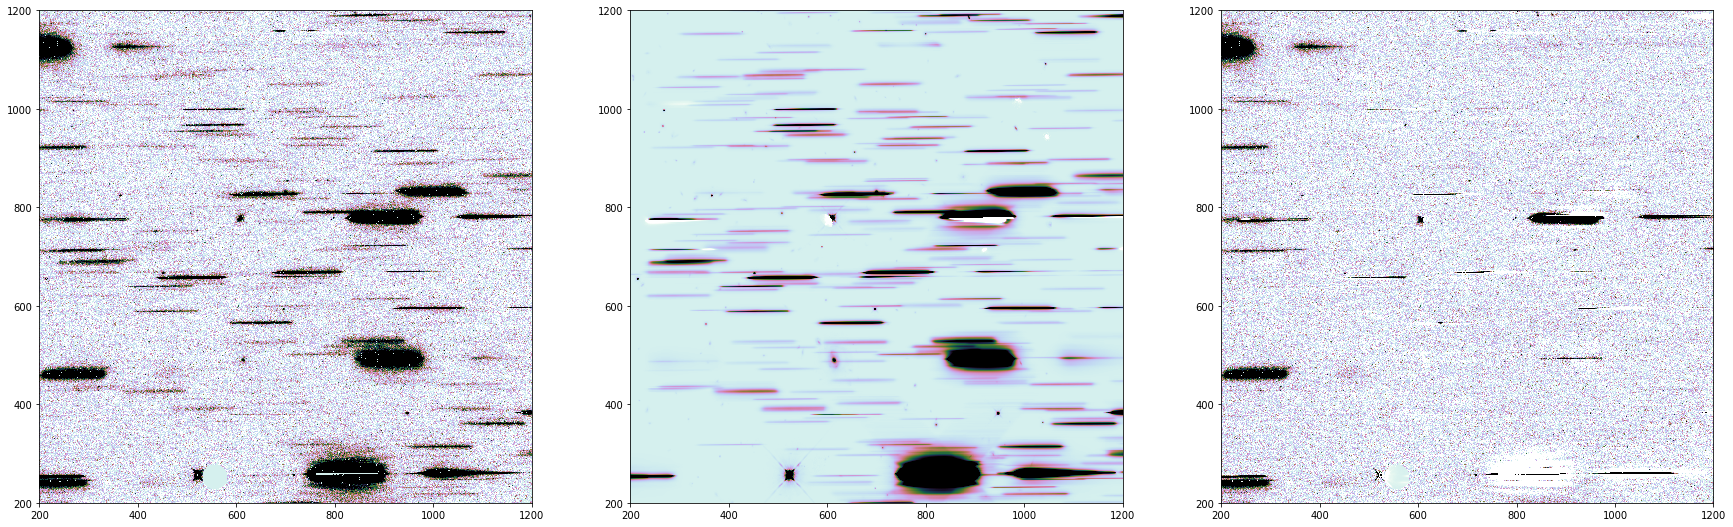

In [44]:
fig.clf()
fig, axes = plt.subplots(1,3, figsize=[30,10])
axes[0].imshow(grp.FLTs[0].grism['SCI'], vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[1].imshow(grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[2].imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')

for ax in axes:
    ax.set_xlim(200,1200) 
    ax.set_ylim(200,1200)
    
    

In [45]:
print('Saving contamination models')
grp.save_full_data()


Saving contamination models
Save ibhj01iqq.01.GrismFLT.fits
Save ibhj01ixq.01.GrismFLT.fits
Save ibhj01j4q.01.GrismFLT.fits
Save ibhj01jbq.01.GrismFLT.fits
Save icxt09f0q.01.GrismFLT.fits
Save icxt09f2q.01.GrismFLT.fits
Save icxt09f5q.01.GrismFLT.fits
Save icxt09f7q.01.GrismFLT.fits
Save icxt10dbq.01.GrismFLT.fits
Save icxt10deq.01.GrismFLT.fits
Save icxt10diq.01.GrismFLT.fits
Save icxt10dkq.01.GrismFLT.fits
Save icxt07dxq.01.GrismFLT.fits
Save icxt07dzq.01.GrismFLT.fits
Save icxt07e2q.01.GrismFLT.fits
Save icxt07e4q.01.GrismFLT.fits
Save icxt08e7q.01.GrismFLT.fits
Save icxt08e9q.01.GrismFLT.fits
Save icxt08ecq.01.GrismFLT.fits
Save icxt08eeq.01.GrismFLT.fits
Save icxt11qiq.01.GrismFLT.fits
Save icxt11qkq.01.GrismFLT.fits
Save icxt11qnq.01.GrismFLT.fits
Save icxt11qpq.01.GrismFLT.fits
Save icxt12qvq.01.GrismFLT.fits
Save icxt12qxq.01.GrismFLT.fits
Save icxt12r0q.01.GrismFLT.fits
Save icxt12r2q.01.GrismFLT.fits


In [46]:
eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', 
                         path_is_env=False)
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Load individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=p.translate_file, 
                        zeropoint_file=None, params=p.params, 
                        load_prior=True, load_products=False)

ep = photoz.EazyPhot(ez, grizli_templates=templ0, zgrid=ez.zgrid)




/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/

<h1><center>Fitting a single object, ID = 43404 </center></h1>

### Retrieve and write-out the 2D spectrum of a single object. These cutouts are referred to as "beams".

In [49]:
id_fit = 43403
beams = grp.get_beams(id_fit, size=80)
print("beams: ", beams)
mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
mb.write_master_fits()



beams:  [<grizli.model.BeamCutout object at 0x1cdce783c8>, <grizli.model.BeamCutout object at 0x1cdce780b8>, <grizli.model.BeamCutout object at 0x1c5a22f048>, <grizli.model.BeamCutout object at 0x1cdce9ab70>, <grizli.model.BeamCutout object at 0x1c5da09fd0>, <grizli.model.BeamCutout object at 0x1ce51e9f98>, <grizli.model.BeamCutout object at 0x1ce51b8eb8>, <grizli.model.BeamCutout object at 0x1ce489c908>, <grizli.model.BeamCutout object at 0x1ce46e49b0>, <grizli.model.BeamCutout object at 0x1ce46c8f98>, <grizli.model.BeamCutout object at 0x1ce4aadda0>, <grizli.model.BeamCutout object at 0x1e0c475c88>, <grizli.model.BeamCutout object at 0x1e0c484ac8>, <grizli.model.BeamCutout object at 0x1ce5163f98>, <grizli.model.BeamCutout object at 0x1ce5148eb8>, <grizli.model.BeamCutout object at 0x1ce49edc18>, <grizli.model.BeamCutout object at 0x1ce44d4f98>, <grizli.model.BeamCutout object at 0x1ce44f0f98>, <grizli.model.BeamCutout object at 0x1cdd3f5da0>, <grizli.model.BeamCutout object at 0x1ce4

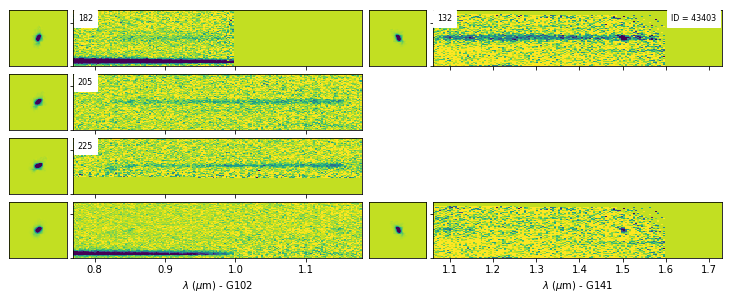

In [50]:
# Fit polynomial model for initial continuum subtraction
wave = np.linspace(2000,2.5e4,100)
poly_templates = grizli.utils.polynomial_templates(
    wave=wave, 
    order=7,
    line=False)

pfit = mb.template_at_z(
    z=0, 
    templates=poly_templates, 
    fit_background=True, 
    fitter='lstsq', 
    fwhm=1400, 
    get_uncertainties=2)


hdu, fig = mb.drizzle_grisms_and_PAs(
    size=32, 
    fcontam=0.2, 
    flambda=False, 
    scale=1, 
    pixfrac=0.5, 
    kernel='point', 
    make_figure=True, 
    usewcs=False, 
    zfit=pfit,
    diff=True)
# Save drizzled ("stacked") 2D trace as PNG and FITS
fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)


In [ ]:
tab = utils.GTable()
tab['ra'] = [mb.ra]
tab['dec'] = [mb.dec]
tab['id'] = id_fit
phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
out = grizli.fitting.run_all(
    id_fit, 
    t0=templ0, 
    t1=templ1, 
    fwhm=1200, 
    zr=[0.0, 3.5], 
    dz=[0.004, 0.0005], 
    fitter='nnls',
    group_name=field,
    fit_stacks=True, 
    prior=None, 
    fcontam=0.,
    pline=pline, 
    mask_sn_limit=7, 
    fit_only_beams=False,
    fit_beams=True, 
    root=field,
    fit_trace_shift=False, 
    phot=phot, 
    verbose=True, 
    scale_photometry= 0, 
    show_beams=True)

In [ ]:
mb, st, fit, tfit, line_hdu = out
fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

fit_hdu.info()
# same as the fit table above, redshift fit to the stacked spectra
fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


# zoom in around the initial best-guess with the individual "beam" spectra
fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

templ = Table(fit_hdu['TEMPL'].data)
print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

# Helper script for plotting them, not generated automatically
fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
plt.close('all')

<h1><center>Grizli products</center></h1>

### Stack of Grism orients

left columns:  G102

right columns: G141

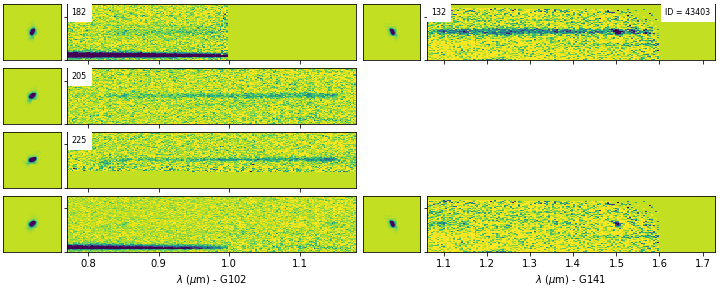

In [51]:
Image(filename = PATH_TO_PREP + '/GS1_43403.stack.png', width = 1000, height = 1000)

### SED fit

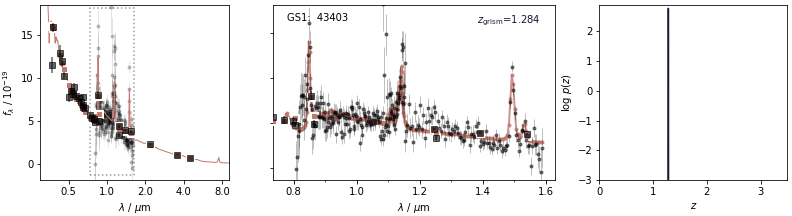

In [52]:
Image(filename = PATH_TO_PREP + '/GS1_43403.sed.png', width = 1000, height = 1000)

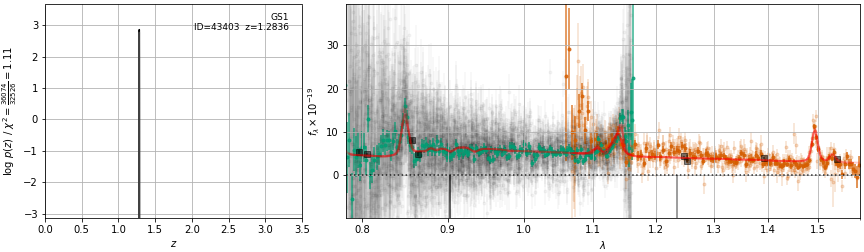

In [53]:
Image(filename = PATH_TO_PREP + '/GS1_43403.full.png', width = 1000, height = 1000)

### Emission Line Map

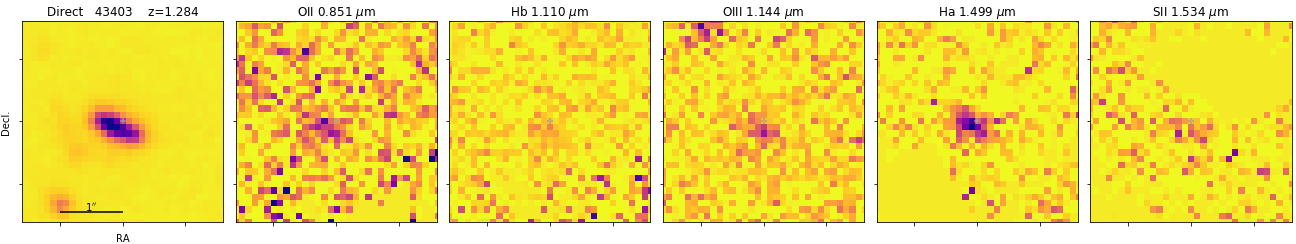

In [54]:
Image(filename = PATH_TO_PREP + '/GS1_43403.line.png', width = 1000, height = 1000)

## Fitting every object in the field with jh mag < 22

In [ ]:
def grizli_fit(grp, id_fit, field = '', ref_filter = 'F105W', use_pz_prior = True, use_phot = True, scale_phot = True, templ0 = None, templ1 = None, ep = None, pline = None):
    beams = grp.get_beams(id_fit, size=80)
    if beams != []:
        print("beams: ", beams)
        mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
        mb.write_master_fits()

        # Fit polynomial model for initial continuum subtraction
        wave = np.linspace(2000,2.5e4,100)
        poly_templates = grizli.utils.polynomial_templates(
            wave=wave, 
            order=7,
            line=False)

        pfit = mb.template_at_z(
            z=0, 
            templates=poly_templates, 
            fit_background=True, 
            fitter='lstsq', 
            fwhm=1400, 
            get_uncertainties=2)


        if pfit != None:
        # Drizzle grisms / PAs
            hdu, fig = mb.drizzle_grisms_and_PAs(
                size=32, 
                fcontam=0.2, 
                flambda=False, 
                scale=1, 
                pixfrac=0.5, 
                kernel='point', 
                make_figure=True, 
                usewcs=False, 
                zfit=pfit,
                diff=True)
            # Save drizzled ("stacked") 2D trace as PNG and FITS
            fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
            hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)



            if use_pz_prior:
                #use redshift prior from z_phot
                prior = np.zeros((2, len(p.tempfilt['zgrid'])))
                prior[0] = p.tempfilt['zgrid']
                prior[1] = p.pz['chi2fit'][:,id]
            else:
                prior = None 
            order = 0



            tab = utils.GTable()
            tab['ra'] = [mb.ra]
            tab['dec'] = [mb.dec]

            tab['id'] = id_fit
            phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
            out = grizli.fitting.run_all(
                id_fit, 
                t0=templ0, 
                t1=templ1, 
                fwhm=1200, 
                zr=[0.0, 3.5], 
                dz=[0.004, 0.0005], 
                fitter='nnls',
                group_name=field,
                fit_stacks=True, 
                prior=None, 
                fcontam=0.,
                pline=pline, 
                mask_sn_limit=7, 
                fit_only_beams=False,
                fit_beams=True, 
                root=field,
                fit_trace_shift=False, 
                phot=phot, 
                verbose=True, 
                scale_photometry=order, 
                show_beams=True)
            mb, st, fit, tfit, line_hdu = out
            fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

            fit_hdu.info()
            # same as the fit table above, redshift fit to the stacked spectra
            fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


            # zoom in around the initial best-guess with the individual "beam" spectra
            fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

            templ = Table(fit_hdu['TEMPL'].data)
            print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

            # Helper script for plotting them, not generated automatically
            fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
            fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
            plt.close('all')
#Fit all objects with MAG_AUTO < 22
if False:
    good = np.where(np.array(grp.catalog['MAG_AUTO']) < 22)[0]
    for g in good:
        id_fit = np.array(grp.catalog['NUMBER'])[g]
        mag_fit = grp.catalog['MAG_AUTO'][g]
        grizli_fit(grp, id_fit = id_fit, field = field,
                   use_pz_prior = False, use_phot = True, scale_phot = True,
                   templ0 = templ0, templ1 = templ1, ep = ep, pline = pline,)
        

